In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [9]:
# Load Data
dataset_path = "/Users/jon/development/university/sis/datasets/tfrecs"

tfrecs_paths = [each for each in os.listdir(dataset_path) if each.endswith(".tfrecord")]

print(tfrecs_paths)

NUM_CLASSES = 26

x_dataset = []
y_dataset = []

raw_dataset = tf.data.TFRecordDataset([os.path.join(dataset_path, each) for each in tfrecs_paths])
print(raw_dataset)

feature_description = {
    'target_label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'landmarks': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
}

def parse_record_fn(example):
    return tf.io.parse_single_example(example, feature_description)

parsed_dataset = raw_dataset.map(parse_record_fn)
# print(parsed_dataset)

for parsed_record in parsed_dataset:
    x_dataset.append(parsed_record['landmarks'].numpy())
    y_dataset.append(parsed_record['target_label'].numpy())

from collections import Counter
unique, counts = np.unique(y_dataset, return_counts=True)
print(dict(zip(unique, counts)))

['train_0094_77929d66-e96c-4cef-b73e-3782fe89b20c.tfrecord', 'train_0112_77ffd52e-32ad-4f3b-93f1-09bd17e92adf.tfrecord', 'train_0055_bed8c139-d368-4dbc-9180-fe52137a79cc.tfrecord', 'train_0091_198d2951-3a68-4708-83e6-015ee2499945.tfrecord', 'train_0046_7e94f8e6-7979-4540-99ed-369dd035fd5d.tfrecord', 'train_0054_769e1320-8841-492a-966f-7a13df1a8df6.tfrecord', 'train_0097_e02cb7ca-355f-4e32-97ea-91490b2f5b6d.tfrecord', 'train_0127_2f760cd9-bc40-4575-89a2-6b76affd9e6e.tfrecord', 'train_0095_1f0e08ac-a935-40c7-8f8e-1ebb6a7ad1e1.tfrecord', 'train_0035_40bc0440-7d10-4d79-8f62-9cacecec308e.tfrecord', 'train_0051_9b6e2c2c-88e4-4f62-ad96-98da6b963c5e.tfrecord', 'train_0047_9d0e6ec3-70df-49fa-9e3a-072bf8c9ba18.tfrecord', 'train_0096_ef512acd-f89a-46ec-9da2-45d9e5cb896c.tfrecord', 'train_0018_b99300a5-bc59-43df-8ae9-b57f23829951.tfrecord', 'train_0040_a824a306-7fc0-491b-9a6c-fc880e9718f4.tfrecord', 'train_0058_36b61851-e3a9-4331-840d-45856cb5dfc7.tfrecord', 'train_0108_c04d49b8-9157-4eae-94b2-c61

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, shuffle=True, random_state=42)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)

print(y_train[0])

(30321, 63, 1)
(30321, 26)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=x_train.shape[1:]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 63, 32)            192       
                                                                 
 conv1d_9 (Conv1D)           (None, 63, 32)            5152      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 31, 32)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 31, 64)            10304     
                                                                 
 conv1d_11 (Conv1D)          (None, 31, 64)            20544     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 15, 64)           0         
 1D)                                                  

In [13]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data=(x_test, y_test))
model.save('model-weights.h5')

Epoch 1/25
948/948 [==============================] - 20s 20ms/step - loss: 1.6666 - accuracy: 0.4675 - categorical_accuracy: 0.4675 - val_loss: 0.2260 - val_accuracy: 0.9153 - val_categorical_accuracy: 0.9153
Epoch 2/25
948/948 [==============================] - 18s 19ms/step - loss: 0.1519 - accuracy: 0.9497 - categorical_accuracy: 0.9497 - val_loss: 0.1358 - val_accuracy: 0.9538 - val_categorical_accuracy: 0.9538
Epoch 3/25
948/948 [==============================] - 20s 21ms/step - loss: 0.0857 - accuracy: 0.9725 - categorical_accuracy: 0.9725 - val_loss: 0.0409 - val_accuracy: 0.9852 - val_categorical_accuracy: 0.9852
Epoch 4/25
948/948 [==============================] - 18s 19ms/step - loss: 0.0693 - accuracy: 0.9777 - categorical_accuracy: 0.9777 - val_loss: 0.0154 - val_accuracy: 0.9950 - val_categorical_accuracy: 0.9950
Epoch 5/25
948/948 [==============================] - 17s 18ms/step - loss: 0.0585 - accuracy: 0.9811 - categorical_accuracy: 0.9811 - val_loss: 0.3048 - val_ac

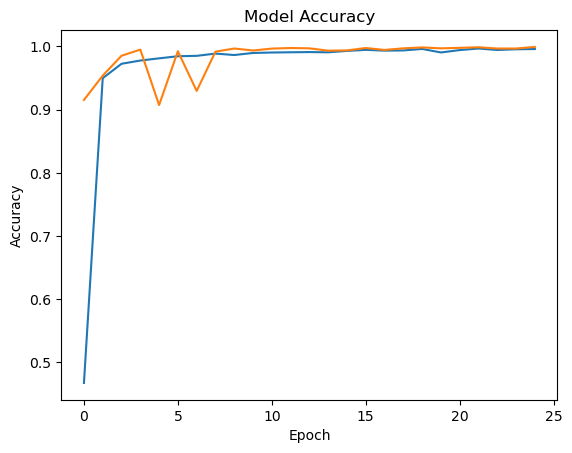

In [14]:
# Graph Metrics/History
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()